In [ ]:
#import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
#import scipy
#import seaborn as sns
#from mlxtend.preprocessing import minmax_scaling
#from sklearn.metrics import roc_curve, auc

#from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
#from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from keras import backend as K
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

#import os

In [ ]:
# test and train file paths
classes = ['food', 'notfood'] #alphabetical order
train_path = '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/'
test_path = '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/test/'
food = glob.glob(train_path + classes[0]+'/*')
notfood = glob.glob(train_path + classes[1]+'/*')
for i in range(10):
  print(food[i])
train_classes = [food,notfood]
train_total = 0
for i in train_classes:
  train_total += len(i)

food_test = glob.glob(test_path + classes[0]+'/*')
notfood_test = glob.glob(test_path + classes[1]+'/*')
test_classes = [food_test,notfood_test]
test_total = 0
for i in test_classes:
  test_total += len(i)

# total train and test images for each category
print('Number of images per class:\nclass\t\ttrain\ttest')
for i in range(len(classes)):
  if len(classes[i])<=5: #extra \t spacing for short words to align every text column 
    print('{}:\t\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
  else:
    print('{}:\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
print('Total:\t\t{}\t{}'.format(train_total,test_total))

['/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/134.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/21063.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/23893.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/38795.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/1784.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/21435.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/25496.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/28613.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/29744.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/788.jpg', '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/food/5062

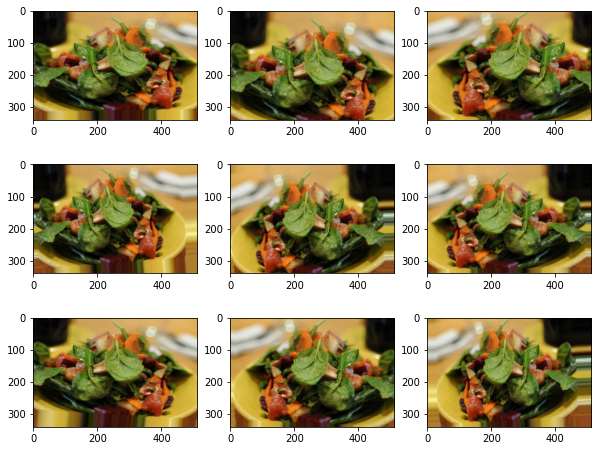

In [ ]:
# example of one image after image augmentation
# load the image
img = load_img(food[50])
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(img, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (percentage of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (percentage of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically because food can't stay upside down on the plate or table.
                 vertical_flip=False)
# prepare iterator #just flow because it is not from directory, its just an image sample
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
fig, axes = plt.subplots(3,3,figsize=(10,8))
for i in range(3):
  for j in range(3):
    # define subplot
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    axes[i,j].imshow(image)
# show the figure
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (percentage of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (percentage of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically because food can't stay upside down on the plate or table and video is vertical so every object is gonna stay as first person view.
                 vertical_flip=False,
                 rescale=1/255) #normalize image, add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory( #images are loaded progressively in alphabetical order and assigned an integer for each class 
        train_path,
        target_size=(224,224),
        class_mode='binary',
        batch_size=16)
test_datagen = ImageDataGenerator(rescale=1/255) # just normalize for testing set
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        class_mode='binary',
        batch_size=16)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


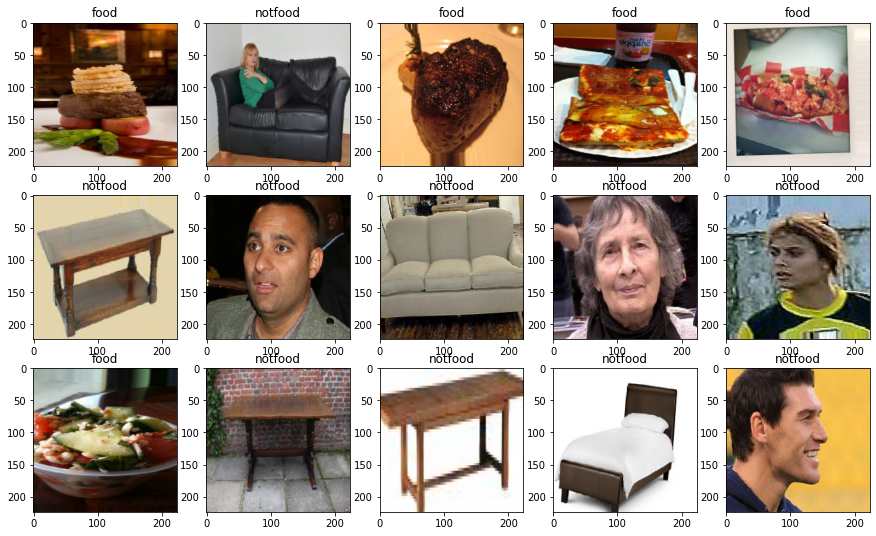

In [ ]:
# preview images from train generator
r = 3; c = 5
n=0
classtolabel = {'0':'food','1':'notfood'} #alphabetical order, each class assigned an integer because of flow_from_directory() function
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(15,9))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = x[1][n].astype('int').astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

In [ ]:
nclass = len(train_generator.class_indices)
base_model = VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.2),#dropout 20% of data to avoid memorization 
  #1 neuron on last layer because be use binary classification (it contains or not the searched class)
  #sigmoid activation for last layer on binary classification because it outputs probability and is good for binary mutually exclusive(food or not food)
  Dense(1, activation = "sigmoid",kernel_initializer='he_normal',kernel_regularizer=l2())])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='modelTest.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

#used binary cross-entropy for loss because the model does a binary classification (it is food or not food)
model.compile(optimizer = 'rmsprop' , loss = "binary_crossentropy", metrics=["accuracy"])

In [ ]:
batch_size = 16
history = model.fit(train_generator,steps_per_epoch=train_total/batch_size,
                              validation_data=test_generator,validation_steps=test_total/batch_size, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/100
  2/125 [..............................] - ETA: 16:41 - loss: 0.6882 - accuracy: 0.5938

KeyboardInterrupt: ignored

In [ ]:
# create another generator for all test images in a single batch
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=test_total)

Found 500 images belonging to 2 classes.


In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/modelBinaryClassificationFoodOrNotfood-VGG16.h5"
model = load_model(export_path_keras)

In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilitie between 0 and 1, where closer to 0 is food and closer to 1 is not food
#print(y_pred_conf)
#y_pred = np.argmax(y_pred_conf,axis=1)
mythreshold = 0.5
y_pred = list(np.concatenate((y_pred_conf>=mythreshold).astype(int)).flat)
#y_pred = (y_pred_conf>=mythreshold).astype(int)
#print(y_pred)
y_label = np.argmax(y_test,axis=1)
#print(y_label)

#accuracy_score(y_label,y_pred_conf.round)
print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 96.8%


In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilitie between 0 and 1, where closer to 0 is food and closer to 1 is not food
#print(y_pred_conf)
#y_pred = np.argmax(y_pred_conf,axis=1)
mythreshold = 0.5
y_pred = list(np.concatenate((y_pred_conf>=mythreshold).astype(int)).flat)
#y_pred = (y_pred_conf>=mythreshold).astype(int)
#print(y_pred)
y_label = np.argmax(y_test,axis=1)
print(y_test)

#accuracy_score(y_label,y_pred_conf.round)
#from sklearn.metrics import jaccard_score
#print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0,